Supervised learning demo
------------------------

Here we demonstrate how to use malt for a simple supervised learning experiment.

## Intallation and imports

In [1]:
# install conda
! pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:34
🔁 Restarting kernel...


In [1]:
%%capture
! mamba install rdkit
! rm -rf malt
! git clone https://github.com/yuanqing-wang/malt.git
! pip install dgl-cu101 dgllife

In [2]:
import torch
import sys
sys.path.append("/content/malt")
import malt

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


Using backend: pytorch


## Grab data

We download the ESOL dataset (https://pubs.acs.org/doi/10.1021/ci034243x), randomly shuffle it and partition into training, validation, and test (80:10:10).

In [18]:
data = malt.data.collections.esol()

Processing dgl graphs from scratch...


KeyboardInterrupt: ignored

In [4]:
ds_tr, ds_vl, ds_te = data.split([8, 1, 1])

## Model definition

In [5]:
model = malt.models.supervised_model.GaussianProcessSupervisedModel(
    representation=malt.models.representation.DGLRepresentation(
        out_features=128,
    ),
    regressor=malt.models.regressor.ExactGaussianProcessRegressor(
        in_features=128, out_features=2,
    ),
    likelihood=malt.models.likelihood.HeteroschedasticGaussianLikelihood(),
)


## Train the model

In [6]:
trainer = malt.trainer.get_default_trainer(without_player=True, n_epochs=1000)
model = trainer(model, ds_tr)

GaussianProcessSupervisedModel(
  (representation): DGLRepresentation(
    (embedding_in): Sequential(
      (0): Linear(in_features=74, out_features=128, bias=True)
      (1): ReLU()
    )
    (gn0): GraphConv(in=128, out=128, normalization=both, activation=None)
    (gn1): GraphConv(in=128, out=128, normalization=both, activation=None)
    (gn2): GraphConv(in=128, out=128, normalization=both, activation=None)
    (embedding_out): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
    (ff): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
    )
    (activation): ReLU()
  )
  (regressor): ExactGaussianProcessRegressor(
    (kernel): RBF()
  )
  (likelihood): HeteroschedasticGaussianLikelihood()
)


/content/malt/malt/models/regressor.py:158: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).transpose(-2, -1).conj().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1285.)
  l_low = torch.cholesky(k_plus_sigma)


## Characterization

In [7]:
r2 = malt.metrics.supervised_metrics.R2()(model, ds_te)
print(r2)

rmse = malt.metrics.supervised_metrics.RMSE()(model, ds_te)
print(rmse)

tensor(0.8678, grad_fn=<RsubBackward1>)
tensor(2.7507, grad_fn=<SqrtBackward0>)


/content/malt/malt/metrics/base_metrics.py:10: UserWarning: Using a target size (torch.Size([112])) that is different to the input size (torch.Size([112, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.sqrt(torch.nn.functional.mse_loss(target, input))


In [11]:
g, y = next(iter(ds_te.view(batch_size=len(ds_te))))

In [15]:
y_hat = model.condition(g).mean.flatten().cpu().detach().numpy()
y = y.cpu().numpy()

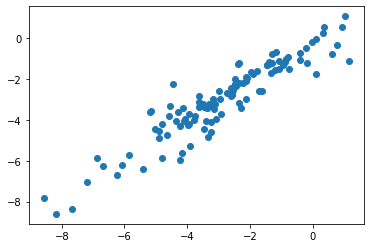

In [17]:
from matplotlib import pyplot as plt
plt.scatter(y, y_hat)